In [1]:
import pandas as pd

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV, train_test_split

from sklearn.metrics import accuracy_score

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
DATABASE_PATH = '/kaggle/input/wine-dataset/Wine dataset.csv'

df = pd.read_csv(DATABASE_PATH)

In [4]:
df.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [6]:
df.isnull().sum().sum()

0

In [7]:
df['class'].nunique()

3

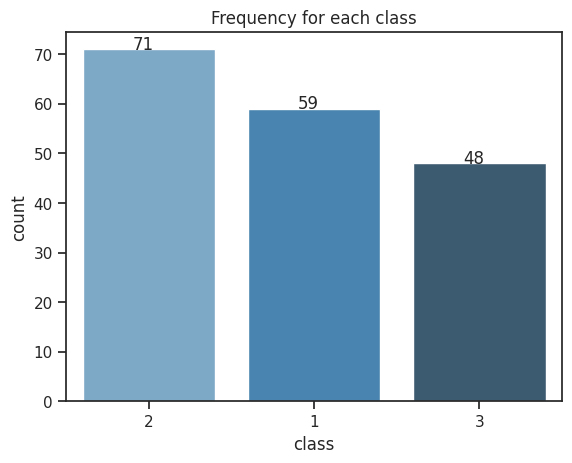

In [8]:
sns.set_theme(style='ticks')

ax = sns.countplot(x=df['class'],palette = 'Blues_d',order = df['class'].value_counts().index)

ax.set_title('Frequency for each class')

for p in ax.patches:

  _x = p.get_x() + p.get_width() - 0.5

  _y = p.get_y() + p.get_height()

  value = int(p.get_height())

  ax.text(_x,_y,value,ha="left")

plt.show()

Здесь мы наблюдаем дисбаланс; для его устранения мы воспользуемся алгоритмом StratifiedKFold.

# Анализ характеристик

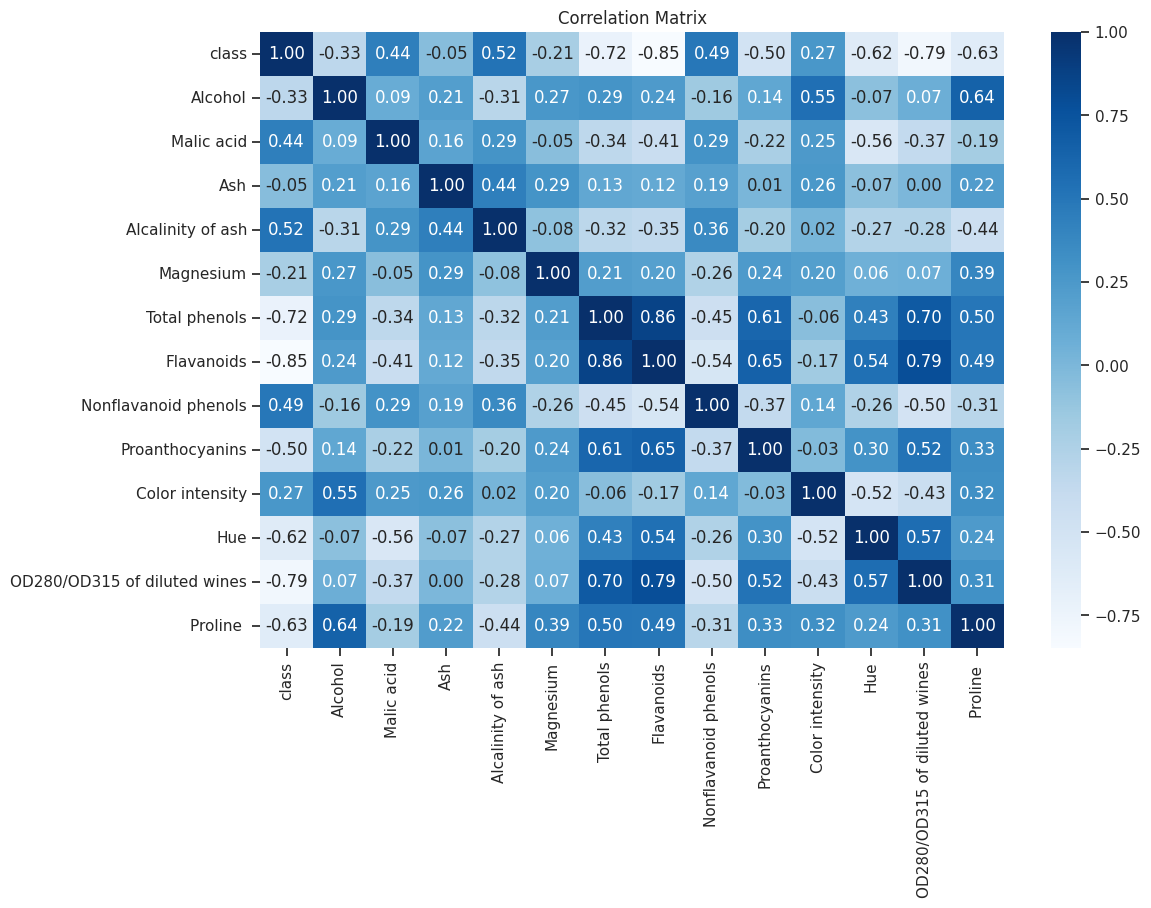

In [9]:
plt.figure(figsize=(12,8))

ax = sns.heatmap(df.corr(numeric_only=True),annot=True,fmt='.2f',cmap='Blues')

ax.set_title('Correlation Matrix')

plt.show()

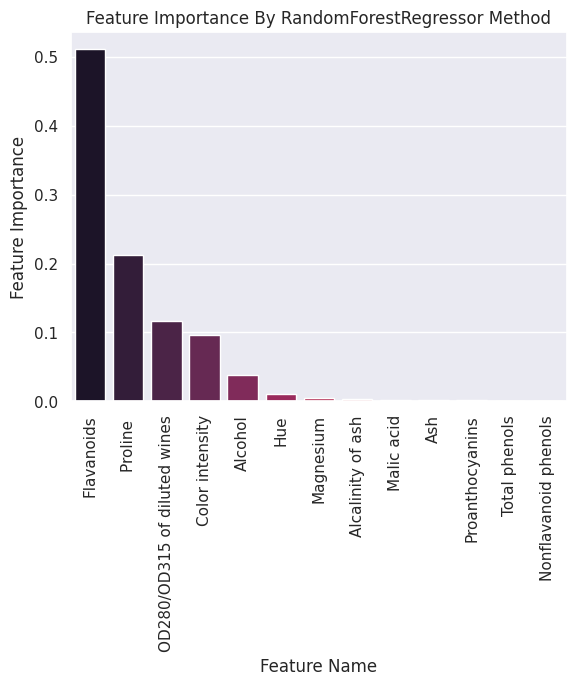

In [10]:
from sklearn.ensemble import RandomForestRegressor

columns = df.drop(['class'],axis=1).columns

X = df.drop(['class'],axis=1).values

y = df['class'].values

model = RandomForestRegressor()

model.fit(X,y)

features_series = pd.Series(data=model.feature_importances_,index=columns).sort_values(ascending=False)



sns.set_theme(style='darkgrid')

ax = sns.barplot(x=features_series.index,y=features_series,palette='rocket')

ax.set_title('Feature Importance By RandomForestRegressor Method')

ax.set_xlabel('Feature Name')

ax.set_ylabel('Feature Importance')

plt.xticks(rotation=90)

plt.show()

# Преобразование данных

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [12]:
X = df.drop(['class'],axis=1).values

y = df['class'].values

minmax = MinMaxScaler()

standard = StandardScaler()

X_minmax = minmax.fit_transform(X)

X_standard = standard.fit_transform(X)

In [13]:
ACTUAL_X = X_standard

ACTUAL_y = y

Данная конфигурация оказалась наилучшей, но вы можете изменить значение, чтобы самостоятельно увидеть другие результаты.

# Определение вспомогательных функций и алгоритмов обучения

In [14]:
algs_series = pd.Series(

    index=['SVC','Random Forest','KNN','Logistic Regression']

)

In [15]:
def find_best_params(estimator,params,X,y):

  cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=5)

  randomSearch = RandomizedSearchCV(

      estimator = estimator,

      param_distributions=params,

      random_state=5, # I like the number 5 :)

      cv=cv

  )

  randomSearch.fit(X,y)

  best_params = randomSearch.best_params_

  print(f'best_score:{randomSearch.best_score_*100:.2f}%')

  return best_params

In [16]:
def predict_and_return_score(estimator,X,y):

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=5)

  estimator.fit(X_train,y_train)

  preds = estimator.predict(X_test)

  return eval(f'{accuracy_score(y_test,preds):.3f}')

# таблица


In [17]:
from sklearn.svm import SVC

In [18]:
params = {

    'C':np.logspace(-3,3,7),

    'gamma':np.logspace(-4,1,6),

    'kernel':['linear','poly','rbf','sigmoid'],

    'decision_function_shape':['ovo','ovr'],

    'random_state':[5]

}

best_params = find_best_params(SVC(),params,ACTUAL_X,ACTUAL_y)

best_score:98.33%


In [19]:
svc_final = SVC(**best_params)

algs_series['SVC'] = predict_and_return_score(svc_final,ACTUAL_X,ACTUAL_y)

algs_series['SVC']

0.944

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
params = {

    'n_estimators':range(100,600,50),

    'criterion':['gini','entropy','log_loss'],

    'random_state':[5]

}

best_params = find_best_params(RandomForestClassifier(),params,ACTUAL_X,ACTUAL_y)

best_score:98.30%


In [22]:
randomForest_final = RandomForestClassifier(**best_params)

algs_series['Random Forest'] = predict_and_return_score(randomForest_final,ACTUAL_X,ACTUAL_y)

algs_series['Random Forest']

1.0

# алгоритм классификации и регрессии

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
params = {

    'n_neighbors':range(1,10),

    'weights':['uniform','distance'],

    'algorithm':['ball_tree','kd_tree','brute']

}

best_params = find_best_params(KNeighborsClassifier(),params,ACTUAL_X,ACTUAL_y)

best_score:97.19%


In [25]:
KNN_final = KNeighborsClassifier(**best_params)

algs_series['KNN'] = predict_and_return_score(KNN_final,ACTUAL_X,ACTUAL_y)

algs_series['KNN']

1.0

# Логистическая регрессия

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
params = {

    'penalty':['none','l2','l1','elasticnet'],

    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],

    'C':np.logspace(-3,3,7)

}

best_params = find_best_params(LogisticRegression(),params,ACTUAL_X,ACTUAL_y)

best_score:98.89%


In [28]:
LR_final = LogisticRegression(**best_params)

algs_series['Logistic Regression'] = predict_and_return_score(LR_final,ACTUAL_X,ACTUAL_y)

algs_series['Logistic Regression']

1.0

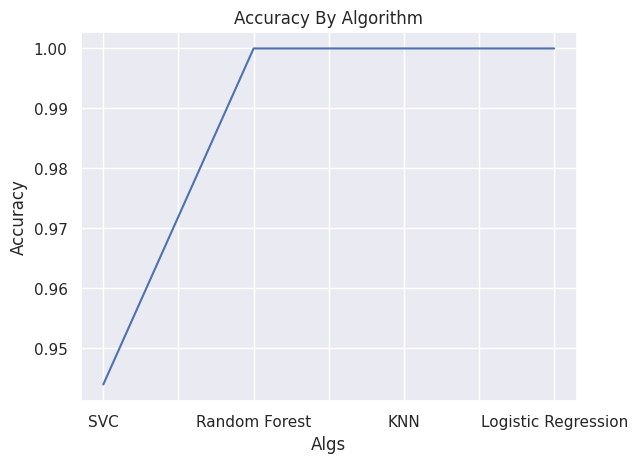

In [29]:
algs_series = algs_series.sort_values()

ax = algs_series.plot()

ax.set_title('Accuracy By Algorithm')

ax.set_xlabel('Algs')

ax.set_ylabel('Accuracy')

plt.show()